<h1> Santander by Random Forest </h1>

In [3]:
import pandas as pd 
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import StandardScaler
from scipy import stats
from matplotlib.legend_handler import HandlerLine2D
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import scipy
from sklearn.model_selection import KFold
from sklearn.model_selection import  StratifiedKFold

In [4]:
def read_input():
    #Basic Input
    data = pd.read_csv("train.csv", header=0) 
    data = data.sample(frac=1).reset_index(drop=True)
    #get the 2d array from pandas
    np_data= data.values
    
    labels = np_data[:,1].astype('int')
    train= np_data[:,2:].astype(np.float32)
    print("Train Shape", train.shape)
    test = pd.read_csv("test.csv", header=0).values 
    ids = test[:,0]
    test= test[:,1:].astype(np.float32)
    print("Test Shape", test.shape)
    return train,labels, test, ids


def remove_outlier(train, labels):
    z = np.abs(stats.zscore(train))
    threshold = 3
    x,y=np.where(z > 3)
    lst= np.unique(x)
    all_indices = [i for i in range(0, train.shape[0])]
    non_outlier_indices = list(set(all_indices)-set(lst))
    train2 = train[non_outlier_indices,:]
    labels2 = labels[non_outlier_indices]
    return train2, labels2

def min_max_normalize(train):
    scaler = MinMaxScaler()
    scaler.fit(train)
    return scaler

#Append few extra features/columns
def append_bin_features(train):
    min_col = np.min(train, axis=1).reshape((-1,1))
    max_col = np.max(train, axis=1).reshape((-1,1))
    mean_col = np.mean(train, axis=1).reshape((-1,1))
    std_col = np.std(train, axis=1).reshape((-1,1))
    sum_col = np.sum(train, axis=1).reshape((-1,1))
    med_col = np.median(train, axis=1).reshape((-1,1))
    

    new_train = train.copy()
    
    new_train=np.column_stack((new_train, min_col))
    new_train=np.column_stack((new_train, max_col))
    new_train=np.column_stack((new_train, mean_col))
    new_train=np.column_stack((new_train, std_col))
    new_train=np.column_stack((new_train, sum_col))
    new_train=np.column_stack((new_train, med_col))
    
    bin_train = train.copy()
    scaler = MinMaxScaler()
    scaler.fit(bin_train)
    min_max_train = np.round(scaler.transform(bin_train) * 100.0)
    
    scaler2 = MinMaxScaler()
    scaler2.fit(min_max_train)
    min_max_train = scaler2.transform(min_max_train)
    
    new_train=np.column_stack((new_train, min_max_train))
    return new_train

def classify(X_train, X_test, y_train, y_test, nest=25, max_depth=15, min_samples_leaf=80,max_features='auto',class_weight={0:1,1:10.5}):
    classifier=RandomForestClassifier(n_estimators=nest, max_depth=max_depth, min_samples_leaf=min_samples_leaf,max_features=max_features, class_weight=class_weight,n_jobs=-1,verbose=False)
    classifier.fit(X_train, y_train)
    return classifier

def get_auc(predictions, actual):
    false_positive_rate, true_positive_rate, thresholds = roc_curve(actual, predictions)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    return roc_auc

In [5]:
#Reading Input
org_train, org_labels, org_test,ids = read_input()

Train Shape (200000, 200)
Test Shape (200000, 200)


In [9]:

#try a basic random forest and see how does it work
#Split the data into train and test (validation)
X_train, X_test, y_train, y_test = train_test_split(org_train, org_labels, test_size=0.20)

classifier= classify(X_train, X_test, y_train, y_test, nest =5, class_weight={0:1,1:1})
train_predictions  =  classifier.predict(X_train)
roc_auc_tr= get_auc(train_predictions, y_train)

validation_predictions = classifier.predict(X_test)
roc_auc_test = get_auc(validation_predictions,y_test)
    
print("Training and Test AUC:", roc_auc_tr, roc_auc_test)
classifier


Training and Test AUC: 0.5 0.5


RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 1},
            criterion='gini', max_depth=15, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=80,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=5, n_jobs=-1, oob_score=False, random_state=None,
            verbose=False, warm_start=False)

<h3> Basic Random Forest is working Randomly, adding outlier removal and Normalization </h3>

In [10]:
train,labels= remove_outlier(org_train, org_labels)
scaler= min_max_normalize(np.concatenate((train, org_test), axis=0))
train = append_bin_features(scaler.transform(train))

In [11]:
X_train, X_test, y_train, y_test = train_test_split(train, labels, test_size=0.20)
classifier= classify(X_train, X_test, y_train, y_test, nest =5, class_weight={0:1,1:1})
train_predictions  =  classifier.predict(X_train)
roc_auc_tr= get_auc(train_predictions, y_train)
validation_predictions = classifier.predict(X_test)
roc_auc_test = get_auc(validation_predictions,y_test)
    
print("Training and Test AUC:", roc_auc_tr, roc_auc_test)
classifier


Training and Test AUC: 0.5 0.5


RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 1},
            criterion='gini', max_depth=15, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=80,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=5, n_jobs=-1, oob_score=False, random_state=None,
            verbose=False, warm_start=False)

<h2> Target 0 is much more frequent than 1, so let's not have equal class weight</h2>

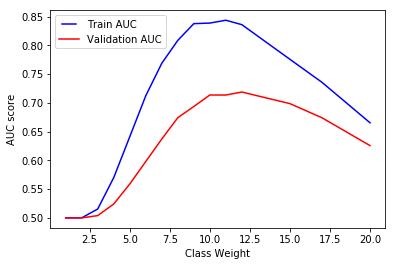

In [15]:
X_train, X_test, y_train, y_test = train_test_split(train, labels, test_size=0.20)
weights = [1, 2, 3, 4, 5,6,7,8,9,10,11,12,15,17, 20]
train_results=[]
test_results=[]
for w in weights:
    classifier= classify(X_train, X_test, y_train, y_test,class_weight = {0:1, 1:w})
    train_predictions  =  classifier.predict(X_train)
    roc_auc_tr= get_auc(train_predictions, y_train)
    train_results.append(roc_auc_tr)
    
    validation_predictions = classifier.predict(X_test)
    roc_auc_test = get_auc(validation_predictions,y_test)
    test_results.append(roc_auc_test)


line1, = plt.plot(weights, train_results, 'b', label='Train AUC')
line2, = plt.plot(weights, test_results, 'r', label='Validation AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Class Weight')
plt.show()


<h2> Tune Number of Trees in Random Forest (Also known as nestimator in short nest)</h2>


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Number of Trees 1


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  16 | elapsed:   12.3s remaining:    7.4s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:   16.4s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  10 out of  16 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  10 out of  16 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


Number of Trees 16


[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:   31.9s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  32 out of  32 | elapsed:    0.6s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  32 out of  32 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


Number of Trees 32


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   34.7s
[Parallel(n_jobs=-1)]: Done  64 out of  64 | elapsed:  1.1min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.5s
[Parallel(n_jobs=12)]: Done  64 out of  64 | elapsed:    1.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done  64 out of  64 | elapsed:    0.3s finished


Number of Trees 64


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   34.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.7min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.5s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    1.7s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.2s


Number of Trees 100


[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.4s finished


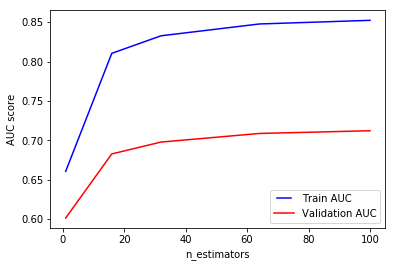

In [118]:
X_train, X_test, y_train, y_test = train_test_split(train, labels, test_size=0.20)
n_estimators = [1, 16, 32, 64, 100]
train_results=[]
test_results=[]
for nest in n_estimators:
    classifier= classify(X_train, X_test, y_train, y_test,nest)
    train_predictions  =  classifier.predict(X_train)
    roc_auc_tr= get_auc(train_predictions, y_train)
    train_results.append(roc_auc_tr)
    
    validation_predictions = classifier.predict(X_test)
    roc_auc_test = get_auc(validation_predictions,y_test)
    test_results.append(roc_auc_test)
    print(nest)


line1, = plt.plot(n_estimators, train_results, 'b', label='Train AUC')
line2, = plt.plot(n_estimators, test_results, 'r', label='Validation AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('n_estimators')
plt.show()


<h2> Tune Max Depth of Tree </h2>

1
2
4
8
16
32
64
128


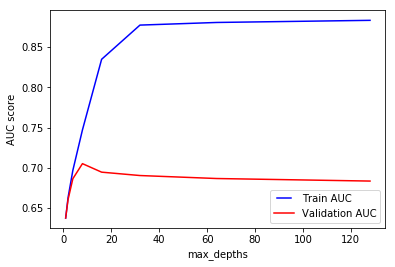

In [17]:
max_depths = [1, 2, 4, 8, 16, 32, 64, 128]

train_results=[]
test_results=[]
for max_depth in max_depths :
    classifier= classify(X_train, X_test, y_train, y_test,max_depth=max_depth)
    train_predictions  =  classifier.predict(X_train)
    roc_auc_tr= get_auc(train_predictions, y_train)
    train_results.append(roc_auc_tr)
    
    validation_predictions = classifier.predict(X_test)
    roc_auc_test = get_auc(validation_predictions,y_test)
    test_results.append(roc_auc_test)

    print(max_depth)

line1, = plt.plot(max_depths, train_results, 'b', label='Train AUC')
line2, = plt.plot(max_depths, test_results, 'r', label='Validation AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('max_depths')
plt.show()

<h2> Tune Min Number of Sample in a Leaf</h2>

[10, 50, 100, 200, 500, 1000]
[10, 50, 100, 200, 500, 1000]
[10, 50, 100, 200, 500, 1000]
[10, 50, 100, 200, 500, 1000]
[10, 50, 100, 200, 500, 1000]
[10, 50, 100, 200, 500, 1000]


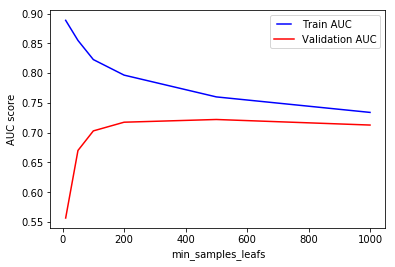

In [18]:
min_samples_leafs = [10, 50, 100, 200, 500, 1000]

train_results=[]
test_results=[]
for min_samples_leaf in min_samples_leafs :
    classifier= classify(X_train, X_test, y_train, y_test,min_samples_leaf=min_samples_leaf )
    train_predictions  =  classifier.predict(X_train)
    roc_auc_tr= get_auc(train_predictions, y_train)
    train_results.append(roc_auc_tr)
    
    validation_predictions = classifier.predict(X_test)
    roc_auc_test = get_auc(validation_predictions, y_test)
    test_results.append(roc_auc_test)
    
    print(min_samples_leaf)
line1, = plt.plot(min_samples_leafs, train_results, 'b', label='Train AUC')
line2, = plt.plot(min_samples_leafs, test_results, 'r', label='Validation AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('min_samples_leafs')
plt.show()

<h2> Max Features Used in a Tree</h2>

10
25
50
75
100
150
200
auto


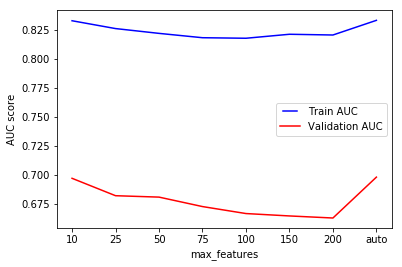

In [20]:
max_features_list= [10,25, 50, 75, 100, 150, 200, 'auto']
train_results=[]
test_results=[]
for max_features in max_features_list :
    classifier= classify(X_train, X_test, y_train, y_test,max_features=max_features)
    train_predictions  =  classifier.predict(X_train)
    roc_auc_tr= get_auc(train_predictions, y_train)
    train_results.append(roc_auc_tr)
    
    validation_predictions = classifier.predict(X_test)
    roc_auc_test = get_auc(validation_predictions, y_test)
    test_results.append(roc_auc_test)
    print(max_features)
    
line1, = plt.plot(max_features_list, train_results, 'b', label='Train AUC')
line2, = plt.plot(max_features_list, test_results, 'r', label='Validation AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('max_features')
plt.show()
